# Tugas Manajeman Proyek

Fajar Muhairi

Muhammad Febriadi

Muhammad Shahreza Khadafi

Muhammad Umar Ar Rashid

In [ ]:
# 0. Install dan import
!pip install -q kagglehub transformers datasets accelerate sentencepiece scikit-learn

import os
import random
import shutil
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt

import torch
import kagglehub
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

In [ ]:
# 1. Config
@dataclass
class Config:
    path_cnn: str = "/content/dataset/Summarized_CNN.csv"
    path_detik: str = "/content/dataset/Summarized_Detik.csv"
    path_kompas: str = "/content/dataset/Summarized_Kompas.csv"
    path_tbh: str = "/content/dataset/Summarized_TurnBackHoax.csv"
    path_extra: str = "/content/dataset/Summarized_2020+.csv"
    model_name: str = "indolem/indobert-base-uncased"
    max_length: int = 256
    train_batch_size: int = 96
    eval_batch_size: int = 384
    grad_accumulation: int = 2
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    num_epochs: int = 3
    seed: int = 42
    balance_minority: bool = True

    output_dir: str = "indobert_hoax_model_v3"


cfg = Config()
set_seed(cfg.seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
# Donwload  data dari kaggle
import kagglehub

# Download latest version
kaggle_cache_dir = kagglehub.dataset_download("fjrmhri/dataset-berita")
print("Path dataset (cache kagglehub):", kaggle_cache_dir)

from pathlib import Path
import shutil

content_dir = Path("/content/dataset")
content_dir.mkdir(parents=True, exist_ok=True)

file_mapping = {
    "Summarized_CNN.csv": ["dataset/Summarized_CNN.csv"],
    "Summarized_Detik.csv": ["dataset/Summarized_Detik.csv"],
    "Summarized_Kompas.csv": ["dataset/Summarized_Kompas.csv"],
    "Summarized_TurnBackHoax.csv": ["dataset/Summarized_TurnBackHoax.csv"],
    "Summarized_2020+.csv": ["dataset/Summarized_2020+.csv"],
}

for dst_name, candidates in file_mapping.items():
    found = None
    for candidate in candidates:
        candidate_path = Path(kaggle_cache_dir) / candidate
        if candidate_path.exists():
            found = candidate_path
            break
    if found is None:
        raise FileNotFoundError(
            f"Tidak menemukan berkas untuk {dst_name} di {kaggle_cache_dir}"
        )
    shutil.copy(found, content_dir / dst_name)
    print(f"Copied {found.name} -> {content_dir / dst_name}")

print("Dataset siap di /content/dataset")

In [ ]:
# 2. data loading dan helpers
BASE_COLS = [
    "url",
    "judul",
    "tanggal",
    "isi_berita",
    "Narasi",
    "Clean Narasi",
    "hoax",
    "summary",
]


def load_single_dataset(path: str, source_name: str) -> pd.DataFrame:
    """Load 1 CSV dan align kolom ke struktur standar."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File tidak ditemukan: {path}")

    print(f"\nMembaca: {path} (source={source_name})")
    df = pd.read_csv(path)
    print("  Kolom:", list(df.columns))

    for col in BASE_COLS:
        if col not in df.columns:
            df[col] = "" if col != "hoax" else np.nan

    df = df[BASE_COLS].copy()
    df["source"] = source_name
    return df


def load_all_datasets(cfg: Config) -> pd.DataFrame:
    frames: List[pd.DataFrame] = []
    frames.append(load_single_dataset(cfg.path_cnn, "cnn"))
    frames.append(load_single_dataset(cfg.path_detik, "detik"))
    frames.append(load_single_dataset(cfg.path_kompas, "kompas"))
    frames.append(load_single_dataset(cfg.path_tbh, "turnbackhoax"))
    frames.append(load_single_dataset(cfg.path_extra, "merged_extra"))

    merged = pd.concat(frames, ignore_index=True)
    print("\nTotal rows (raw merged):", len(merged))
    return merged

In [ ]:
# 3. preprossesing dan labeling
def build_training_dataframe(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()

    def pick_text(row):
        for col in ["Clean Narasi", "Narasi", "isi_berita", "judul"]:
            val = row.get(col, "")
            if isinstance(val, str) and val.strip():
                return val.strip()
        return ""

    df["text"] = df.apply(pick_text, axis=1)
    df["text"] = df["text"].astype(str).str.strip()
    before_empty = len(df)
    df = df[df["text"] != ""].reset_index(drop=True)
    print(f"Baris tanpa teks dibuang: {before_empty - len(df)}")

    df["hoax_num"] = pd.to_numeric(df["hoax"], errors="coerce")

    mask_nan = df["hoax_num"].isna()
    df.loc[(df["source"].isin(["cnn", "detik", "kompas"])) & mask_nan, "hoax_num"] = 0
    df.loc[(df["source"] == "turnbackhoax") & mask_nan, "hoax_num"] = 1
    df.loc[(df["source"] == "merged_extra") & mask_nan, "hoax_num"] = 0

    before_nan = len(df)
    df = df[df["hoax_num"].isin([0, 1])].reset_index(drop=True)
    print(f"Baris dengan label hoax NaN dibuang: {before_nan - len(df)}")

    df["label"] = df["hoax_num"].astype(int)
    df = df.drop(columns=["hoax_num"])

    before_dupes = len(df)
    df = df.drop_duplicates(subset=["text", "label"])
    print(f"Baris duplikat (text+label) dibuang: {before_dupes - len(df)}")

    print("\nDistribusi label (0=non-hoax, 1=hoax):")
    print(df["label"].value_counts(normalize=False))
    print("\nDistribusi label per source:")
    print(df.groupby("source")["label"].value_counts().unstack(fill_value=0))

    return df

In [ ]:
# 4. Split train / val / test / balacing
def stratified_splits(df: pd.DataFrame, seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    70% train, 15% val, 15% test dengan stratify.
    """
    train_df, temp_df = train_test_split(
        df,
        test_size=0.30,
        stratify=df["label"],
        random_state=seed,
    )

    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.50,
        stratify=temp_df["label"],
        random_state=seed,
    )

    print("\nSplit sizes:")
    print("  Train:", len(train_df))
    print("  Val  :", len(val_df))
    print("  Test :", len(test_df))

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


def balance_minority_only_train(train_df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    Oversampling kelas minoritas di TRAIN saja.
    """
    counts = train_df["label"].value_counts()
    print("\nDistribusi TRAIN sebelum balancing:")
    print(counts)

    if len(counts) != 2:
        print("Label tidak biner atau hanya satu kelas, balancing dilewati.")
        return train_df

    max_count = counts.max()
    frames = []
    for label_val, df_label in train_df.groupby("label"):
        if len(df_label) < max_count:
            df_label = resample(
                df_label,
                replace=True,
                n_samples=max_count,
                random_state=seed,
            )
        frames.append(df_label)

    train_bal = pd.concat(frames, ignore_index=True)
    train_bal = train_bal.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    print("\nDistribusi TRAIN setelah balancing:")
    print(train_bal["label"].value_counts())
    return train_bal

In [ ]:
# login huggingface(masukkan token)
from huggingface_hub import login

login()

In [ ]:
# 5. Convert huggingface datasets dan tokenisasi
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=cfg.max_length,
    )

def prepare_datasets(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame):
    train_ds = Dataset.from_pandas(train_df[["text", "label", "source"]])
    val_ds = Dataset.from_pandas(val_df[["text", "label", "source"]])
    test_ds = Dataset.from_pandas(test_df[["text", "label", "source"]])

    for ds in [train_ds, val_ds, test_ds]:
        for col in list(ds.column_names):
            if col.startswith("__index_level"):
                ds = ds.remove_columns(col)

    train_ds = train_ds.map(tokenize_batch, batched=True)
    val_ds = val_ds.map(tokenize_batch, batched=True)
    test_ds = test_ds.map(tokenize_batch, batched=True)

    cols = ["input_ids", "attention_mask", "label"]
    train_ds.set_format(type="torch", columns=cols)
    val_ds.set_format(type="torch", columns=cols)
    test_ds.set_format(type="torch", columns=cols)

    return train_ds, val_ds, test_ds

In [ ]:
# 6. Model & setup training
label2id = {"not_hoax": 0, "hoax": 1}
id2label = {v: k for k, v in label2id.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    cfg.model_name,
    num_labels=2,
    id2label=id2label,
    label2id={v: k for k, v in id2label.items()},
).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1
    )
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "precision_weighted": prec_w,
        "recall_weighted": rec_w,
        "f1_weighted": f1_w,
    }

training_args = TrainingArguments(
    output_dir=cfg.output_dir,
    per_device_train_batch_size=cfg.train_batch_size,
    per_device_eval_batch_size=cfg.eval_batch_size,
    gradient_accumulation_steps=cfg.grad_accumulation,
    num_train_epochs=cfg.num_epochs,
    learning_rate=cfg.learning_rate,
    weight_decay=cfg.weight_decay,
    logging_steps=100,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    do_train=True,
    do_eval=True,
    seed=cfg.seed,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=None,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3422404188.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 7. pipiline end to end
df_raw = load_all_datasets(cfg)
df_all = build_training_dataframe(df_raw)

train_df, val_df, test_df = stratified_splits(df_all, seed=cfg.seed)

if cfg.balance_minority:
    train_df = balance_minority_only_train(train_df, seed=cfg.seed)

train_ds, val_ds, test_ds = prepare_datasets(train_df, val_df, test_df)

trainer.train_dataset = train_ds
trainer.eval_dataset = val_ds

train_result = trainer.train()
print("\nTraining selesai.")
print(train_result)

print("\n=== Evaluasi di VALIDATION set ===")
val_metrics = trainer.evaluate(val_ds)
print(val_metrics)

print("\n=== Evaluasi di TEST set ===")
test_metrics = trainer.evaluate(test_ds)
print(test_metrics)


Membaca: /content/dataset/Summarized_CNN.csv (source=cnn)
  Kolom: ['url', 'judul', 'tanggal', 'isi_berita', 'Narasi', 'Clean Narasi', 'hoax', 'summary']

Membaca: /content/dataset/Summarized_Detik.csv (source=detik)
  Kolom: ['url', 'judul', 'tanggal', 'isi_berita', 'Narasi', 'Clean Narasi', 'hoax', 'summary']

Membaca: /content/dataset/Summarized_Kompas.csv (source=kompas)
  Kolom: ['url', 'judul', 'tanggal', 'isi_berita', 'Narasi', 'Clean Narasi', 'hoax', 'summary']

Membaca: /content/dataset/Summarized_TurnBackHoax.csv (source=turnbackhoax)
  Kolom: ['url', 'judul', 'tanggal', 'isi_berita', 'Narasi', 'Clean Narasi', 'hoax', 'summary']

Membaca: /content/dataset/merged_clean_filtered_2020plus_halfNaT.csv (source=merged_extra)


/tmp/ipython-input-2187956815.py:23: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


  Kolom: ['url', 'judul', 'tanggal', 'isi_berita', 'Narasi', 'Clean Narasi', 'hoax', 'summary', 'source_file']

Total rows (raw merged): 177288
Baris tanpa teks dibuang: 0
Baris dengan label hoax NaN dibuang: 0
Baris duplikat (text+label) dibuang: 1067

Distribusi label (0=non-hoax, 1=hoax):
label
0    164268
1     11953
Name: count, dtype: int64

Distribusi label per source:
label              0      1
source                     
cnn             4216      0
detik           4213      0
kompas          4216      0
merged_extra  151623      0
turnbackhoax       0  11953

Split sizes:
  Train: 123354
  Val  : 26433
  Test : 26434

Distribusi TRAIN sebelum balancing:
label
0    114987
1      8367
Name: count, dtype: int64

Distribusi TRAIN setelah balancing:
label
0    114987
1    114987
Name: count, dtype: int64


Map:   0%|          | 0/229974 [00:00<?, ? examples/s]

Map:   0%|          | 0/26433 [00:00<?, ? examples/s]

Map:   0%|          | 0/26434 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Step,Training Loss
100,0.141500
200,0.037100
300,0.026700
400,0.019800
500,0.013100
600,0.008700
700,0.008300
800,0.006100
900,0.006300
1000,0.005300



Training selesai.
TrainOutput(global_step=3594, training_loss=0.008522197576063494, metrics={'train_runtime': 6981.8463, 'train_samples_per_second': 98.817, 'train_steps_per_second': 0.515, 'total_flos': 9.076305276804096e+16, 'train_loss': 0.008522197576063494, 'epoch': 3.0})

=== Evaluasi di VALIDATION set ===


{'eval_loss': 0.012434526346623898, 'eval_accuracy': 0.9983354140657511, 'eval_precision': 0.992121553179516, 'eval_recall': 0.9832682654768544, 'eval_f1': 0.9876750700280112, 'eval_precision_weighted': 0.9983313817095628, 'eval_recall_weighted': 0.9983354140657511, 'eval_f1_weighted': 0.9983319540384751, 'eval_runtime': 94.2364, 'eval_samples_per_second': 280.497, 'eval_steps_per_second': 0.732, 'epoch': 3.0}

=== Evaluasi di TEST set ===
{'eval_loss': 0.012139661237597466, 'eval_accuracy': 0.9982976469698116, 'eval_precision': 0.9937853107344633, 'eval_recall': 0.981037367540435, 'eval_f1': 0.9873701936570306, 'eval_precision_weighted': 0.9982934390662512, 'eval_recall_weighted': 0.9982976469698116, 'eval_f1_weighted': 0.9982925494862664, 'eval_runtime': 93.5916, 'eval_samples_per_second': 282.44, 'eval_steps_per_second': 0.737, 'epoch': 3.0}



--- Validation Classification Report ---
              precision    recall  f1-score   support

    not_hoax     0.9988    0.9994    0.9991     24640
        hoax     0.9921    0.9833    0.9877      1793

    accuracy                         0.9983     26433
   macro avg     0.9955    0.9914    0.9934     26433
weighted avg     0.9983    0.9983    0.9983     26433


--- Validation Confusion Matrix ---
[[24626    14]
 [   30  1763]]


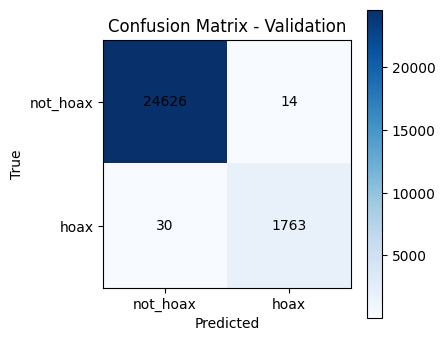


--- Test Classification Report ---
              precision    recall  f1-score   support

    not_hoax     0.9986    0.9996    0.9991     24641
        hoax     0.9938    0.9810    0.9874      1793

    accuracy                         0.9983     26434
   macro avg     0.9962    0.9903    0.9932     26434
weighted avg     0.9983    0.9983    0.9983     26434


--- Test Confusion Matrix ---
[[24630    11]
 [   34  1759]]


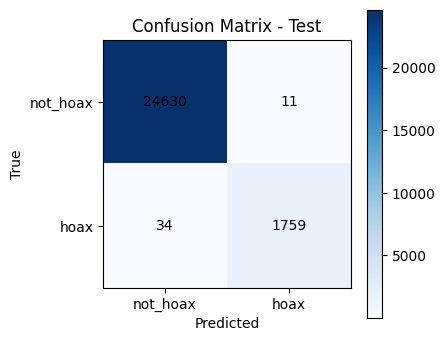

In [ ]:
# 8. Laporan detail
def detailed_report(trainer: Trainer, dataset: Dataset, split_name: str):
    preds_output = trainer.predict(dataset)
    y_true = preds_output.label_ids
    y_pred = np.argmax(preds_output.predictions, axis=-1)

    target_names = ["not_hoax", "hoax"]
    print(f"\n--- {split_name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    print(f"\n--- {split_name} Confusion Matrix ---")
    print(cm)

    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(target_names)
    ax.set_yticklabels(target_names)
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.title(f"Confusion Matrix - {split_name}")
    plt.colorbar(im, ax=ax)
    plt.show()


detailed_report(trainer, val_ds, "Validation")
detailed_report(trainer, test_ds, "Test")

In [ ]:
# 9. Simpan model dan tokenizer
os.makedirs(cfg.output_dir, exist_ok=True)
trainer.model.save_pretrained(cfg.output_dir)
tokenizer.save_pretrained(cfg.output_dir)
print(f"\nModel & tokenizer disimpan ke: {cfg.output_dir}")


Model & tokenizer disimpan ke: indobert_hoax_model_v3


In [ ]:
# 10. Download model
import shutil
from google.colab import files

output_filename = f"{cfg.output_dir}.zip"

print(f"Membuat zip: {cfg.output_dir}...")
shutil.make_archive(cfg.output_dir, 'zip', cfg.output_dir)

print(f"Mengunduh file: {output_filename}...")
files.download(output_filename)
print("Akhirnya siap!")

Membuat file ZIP dari direktori: indobert_hoax_model_v3...
